In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import math
import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print("Running on PyMC3 v{}".format(pm.__version__))
print("Running on arviz v{}".format(az.__version__))

Running on PyMC3 v5.7.2
Running on arviz v0.16.1


In [4]:
train = pd.read_csv('classify/train_clf.csv')
test = pd.read_csv('classify/test_clf.csv')
X_train = train[['a', 'b', 'c']]
y_train = train['y']
X_test = test

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# классы сбалансированы, все ок
y_train.sum()

51.0

In [6]:
with pm.Model() as model_1:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=2, shape=len(X_train[0]))

    μ = α_tmp + pm.math.dot(X_train, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))

    yl = pm.Bernoulli('yl', p=θ, observed=y_train)

    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([[<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

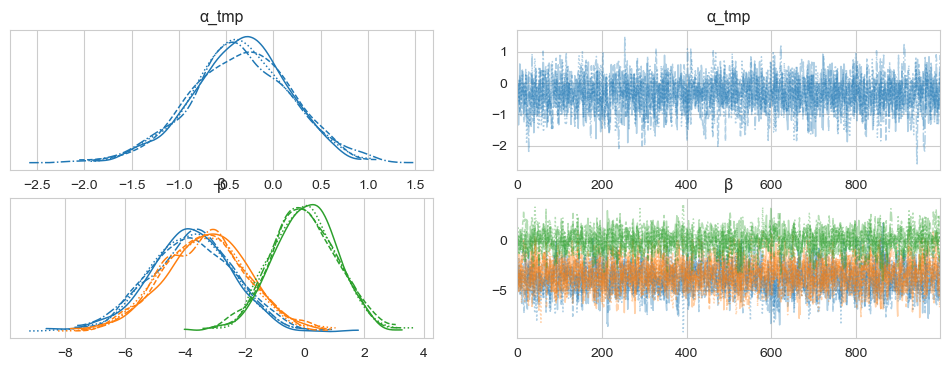

In [7]:
az.plot_trace(trace_1, var_names = ['α_tmp','β'])

In [8]:
df = az.summary(trace_1, var_names=['α_tmp','β'] )
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-0.355,0.529,-1.386,0.614,0.011,0.009,2146.0,2107.0,1.0
β[0],-3.801,1.407,-6.315,-1.089,0.036,0.025,1554.0,1977.0,1.0
β[1],-3.352,1.417,-6.123,-0.804,0.037,0.026,1445.0,2080.0,1.0
β[2],-0.002,1.094,-1.983,2.082,0.031,0.022,1274.0,1908.0,1.0


Видно, что третий признак шумовой

In [9]:
α_tmp = trace_1.posterior['α_tmp'].mean().item()
β_1 = trace_1.posterior['β'].mean(axis=0).mean(axis=0)[0].item()
β_2 = trace_1.posterior['β'].mean(axis=0).mean(axis=0)[1].item()

In [10]:
def sigmoid(x):
  res = []
  for i in x:
    res.append(1 / (1 + math.exp(-i)))
  return np.array(res)

μ = α_tmp + β_1*X_train[:, 0] +  β_2*X_train[:, 1]
y_train_pred = sigmoid(μ) > 0.5

In [11]:
# Точность (Accuracy)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Матрица ошибок (Confusion Matrix)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Отчет о классификации (Classification Report)
class_report = classification_report(y_train, y_train_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.96
Confusion Matrix:
[[47  2]
 [ 2 49]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        49
         1.0       0.96      0.96      0.96        51

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [12]:
μ = α_tmp + β_1*X_test[:, 0] +  β_2*X_test[:, 1]
y_pred = sigmoid(μ) > 0.5

In [13]:
y_pred

array([False, False, False,  True,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True, False,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False, False,  True, False, False,  True,
        True, False, False,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False, False,
        True])

In [23]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.96

### ВТОРАЯ ЧАСТЬ ЗАДАНИЯ


In [14]:
print(X_train[y_train == 0][:, 0].std())
print(X_train[y_train == 0][:, 1].std())
print(X_train[y_train == 1][:, 0].std())
print(X_train[y_train == 1][:, 1].std())

0.6719568939449241
0.6686788640188757
0.5096426948054846
0.6258704510917122


In [15]:
with pm.Model() as lda2:
    μ_1 = pm.Normal('μ_1', mu=0, sigma=20, shape=2)
    features_1 = pm.Normal('features_1', mu=μ_1, sigma=0.63, observed=X_train[y_train == 0][:, [0, 1]])
    trace_lda_1 = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [16]:
with pm.Model() as lda2:
    μ_2 = pm.Normal('μ_2', mu=0, sigma=20, shape=2)
    features_2 = pm.Normal('features_2', mu=μ_2, sigma=0.63, observed=X_train[y_train == 1][:, [0, 1]])
    trace_lda_2 = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [17]:
μ_11 = trace_lda_1.posterior['μ_1'].mean(axis=0).mean(axis=0)[0].item()
μ_12 = trace_lda_1.posterior['μ_1'].mean(axis=0).mean(axis=0)[1].item()
μ_21 = trace_lda_2.posterior['μ_2'].mean(axis=0).mean(axis=0)[0].item()
μ_22 = trace_lda_2.posterior['μ_2'].mean(axis=0).mean(axis=0)[1].item()

In [18]:
print(μ_11, μ_12, μ_21, μ_22)

0.8192793187091761 0.7787338885414924 -0.7879439204847525 -0.7471890226654739


In [19]:
y_train_pred_lda = []
for i in X_train:
  first = (i[0]-μ_11)**2 + (i[1]-μ_12)**2
  second = (i[0]-μ_21)**2 + (i[1]-μ_22)**2
  if first < second:
    y_train_pred_lda.append(0)
  else:
    y_train_pred_lda.append(1)

In [20]:
# Точность (Accuracy)
accuracy = accuracy_score(y_train, y_train_pred_lda)
print("Accuracy:", accuracy)

# Матрица ошибок (Confusion Matrix)
conf_matrix = confusion_matrix(y_train, y_train_pred_lda)
print("Confusion Matrix:")
print(conf_matrix)

# Отчет о классификации (Classification Report)
class_report = classification_report(y_train, y_train_pred_lda)
print("Classification Report:")
print(class_report)

Accuracy: 0.96
Confusion Matrix:
[[46  3]
 [ 1 50]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        49
         1.0       0.94      0.98      0.96        51

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [25]:
y_pred_lda = []
for i in X_test:
  first = (i[0]-μ_11)**2 + (i[1]-μ_12)**2
  second = (i[0]-μ_21)**2 + (i[1]-μ_22)**2
  if first < second:
    y_pred_lda.append(0)
  else:
    y_pred_lda.append(1)

In [26]:
y_pred_lda = np.array(y_pred_lda)
y_pred_lda

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [27]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred_lda)

0.95